## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [3]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [4]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [5]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [6]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

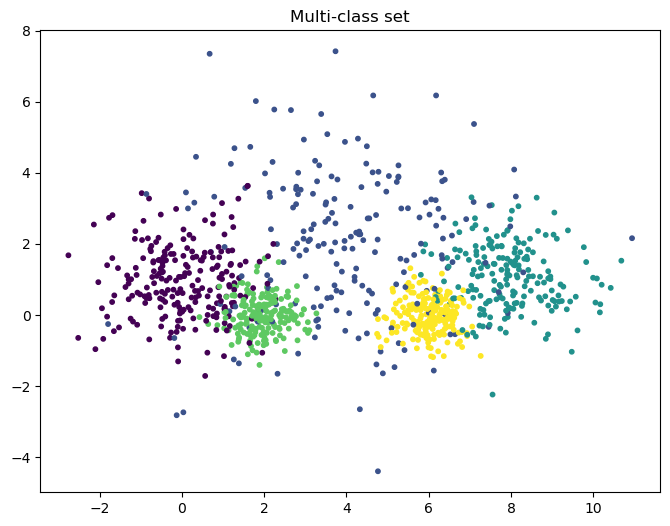

In [7]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

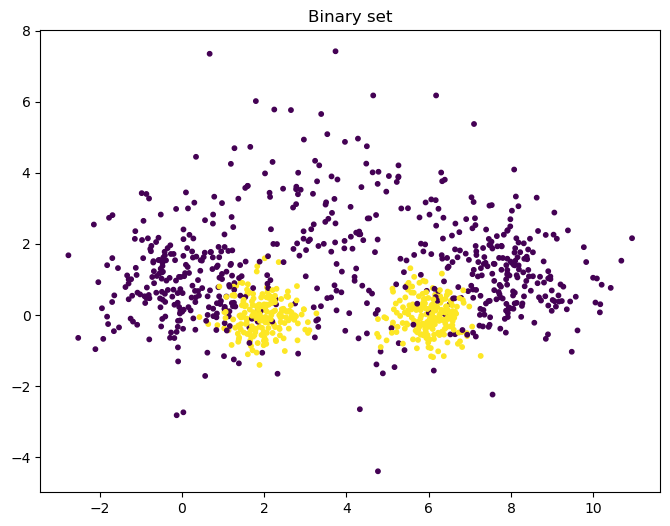

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [9]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [273]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

    def MSE(self, x, y):
        return sum((x - y)**2)/x.shape[0]
    
    # Logistic (Used in Logistic Regression)
    def logistic(self, x):
        return 1/(1+np.exp(-x))
    
    # Binary cross-entropy loss for logistic regression
    def CEL(self, t_train, y_pred):
        # Avoid ln(0) and ln(1)
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        loss = 0
        for i in range(len(y_pred)):
            loss -= np.log((y_pred[i]**(t_train[i]))*(1 - y_pred[i])**(1 - t_train[i]))
        return np.mean(loss)
    

    # Througout the assignment I have tried different approaches as the plots were not as I expected.
    # Binary cross-entropy loss for logistic regression
    # def BCE(self, t_train, y_pred):
    #     loss = - t_train * np.log(y_pred) - (1 - t_train) * np.log(1 - y_pred)
    #     return np.mean(loss)
    
    # # Binary cross-entropy loss for logistic regression
    # def BCE(self, x, t_train, y_pred):
    #     N = len(y_pred)
    #     sum = 0
    #     for j in range(N):
    #         for i in range(len(x[0])):
    #             sum -= (t_train[j] - y_pred[j])*x[j][i]
    #     return sum/N
    
    def accuracy(self, predicted, gold):
        return np.mean(predicted == gold)

In [197]:
class NumpyLinRegClass(NumpyClassifier): # Gradient descent batch training?

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, X_test, t_test, eta = 0.1, epochs=10):
        # eta - learning rate
        """X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N,
        the targets values for the training data"""

        # X_train_no_bias = np.copy(X_train)

        (N, m) = X_train.shape
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
        
        self.weights = weights = np.zeros(m + 1)
        # Added for Task:Loss {
        self.loss = loss = []
        self.accuracy_f = accuracy_f = []
        #}

        for e in range(epochs):
            weights -= eta / N * X_train.T @ (X_train @ weights - t_train)
            # Task: loss {
            loss.append(self.MSE(t_train, X_train @ weights))
            # loss.append(self.MSE(t_train, self.predict(X_train_no_bias)))
            accuracy_f.append(self.accuracy(self.predict(X_test), t_test))
            # accuracy_f.append(np.mean(self.predict(X_val) == t_val))
            # accuracy_f.append(np.mean(self.predict(X_train_no_bias) == t_val))
            # }
    
    # Task:Loss {
    def mse_loss(self):
        return self.loss
    
    def accuracy_func(self):
        return self.accuracy_f
    # }
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [198]:
def accuracy_(predicted, gold):
    return np.mean(predicted == gold)

In [199]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, X_val, t2_val)
print(accuracy_(cl.predict(X_val), t2_val))
print(cl.accuracy(cl.predict(X_val), t2_val))

0.522
0.522


The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [200]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

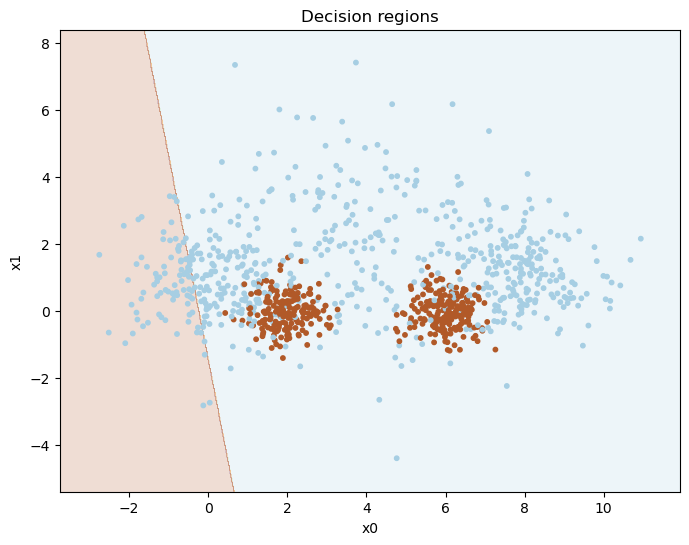

In [201]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried out.

When you are satisfied with the result, you may plot the decision boundaries, as above.

In [202]:
# Finding best hyper-parameters
def test_hyperpars(X_train, t_train, X_val, t_val, eta_values, epoch_values, cl = cl):
    # Testing various eta and epochs to increase accuracy
    
    for et in eta_values:
        for ep in epoch_values:
            cl.fit(X_train, t_train, X_val, t_val, eta = et, epochs = ep)
            print(f"eta: {et:5}    epochs: {ep:5}    accuracy: {cl.accuracy(cl.predict(X_val), t_val):8.3f}")
     

In [41]:
eta_values = [0.3, 0.1, 0.05, 0.01, 0.005, 0.001]
epoch_values = [10, 50, 100, 500, 1000, 5000] 

test_hyperpars(X_train, t2_train, X_val, t2_val, eta_values, epoch_values)

eta:   0.3    epochs:    10    accuracy:    0.516
eta:   0.3    epochs:    50    accuracy:    0.516
eta:   0.3    epochs:   100    accuracy:    0.516
eta:   0.3    epochs:   500    accuracy:    0.576


/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/1619145062.py:5: RuntimeWarning: overflow encountered in double_scalars
  return sum((x - y)**2)/x.shape[0]
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/1619145062.py:5: RuntimeWarning: overflow encountered in square
  return sum((x - y)**2)/x.shape[0]
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2818609812.py:28: RuntimeWarning: overflow encountered in matmul
  loss.append(self.MSE(t_train, X_train @ weights))
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2818609812.py:48: RuntimeWarning: overflow encountered in matmul
  ys = X @ self.weights
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2818609812.py:26: RuntimeWarning: overflow encountered in matmul
  weights -= eta / N * X_train.T @ (X_train @ weights - t_train)
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2818609812.py:26: RuntimeWarning: invalid value encountered in mat

eta:   0.3    epochs:  1000    accuracy:    0.576
eta:   0.3    epochs:  5000    accuracy:    0.576
eta:   0.1    epochs:    10    accuracy:    0.522
eta:   0.1    epochs:    50    accuracy:    0.516
eta:   0.1    epochs:   100    accuracy:    0.516
eta:   0.1    epochs:   500    accuracy:    0.516
eta:   0.1    epochs:  1000    accuracy:    0.516


/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2818609812.py:28: RuntimeWarning: invalid value encountered in matmul
  loss.append(self.MSE(t_train, X_train @ weights))
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2818609812.py:48: RuntimeWarning: invalid value encountered in matmul
  ys = X @ self.weights


eta:   0.1    epochs:  5000    accuracy:    0.576
eta:  0.05    epochs:    10    accuracy:    0.506
eta:  0.05    epochs:    50    accuracy:    0.590
eta:  0.05    epochs:   100    accuracy:    0.658
eta:  0.05    epochs:   500    accuracy:    0.704
eta:  0.05    epochs:  1000    accuracy:    0.704
eta:  0.05    epochs:  5000    accuracy:    0.704
eta:  0.01    epochs:    10    accuracy:    0.502
eta:  0.01    epochs:    50    accuracy:    0.504
eta:  0.01    epochs:   100    accuracy:    0.560
eta:  0.01    epochs:   500    accuracy:    0.658
eta:  0.01    epochs:  1000    accuracy:    0.686
eta:  0.01    epochs:  5000    accuracy:    0.704
eta: 0.005    epochs:    10    accuracy:    0.576
eta: 0.005    epochs:    50    accuracy:    0.478
eta: 0.005    epochs:   100    accuracy:    0.504
eta: 0.005    epochs:   500    accuracy:    0.588
eta: 0.005    epochs:  1000    accuracy:    0.658
eta: 0.005    epochs:  5000    accuracy:    0.704
eta: 0.001    epochs:    10    accuracy:    0.576


The effect of the hyper-parameter settings on the accuracy is printed above.

A learning rate of 0.3 and 0.1 is too high and diverges. Lower epoch values result in lower accuracy independant of the learning rate. 

An eta of 0.3 and 0.1 and few epochs yields the lowest accuracies of 0.516.

Optimizing test intervals:
The higest accuracy with the least amount of epochs is:
eta:  0.05    epochs:   500    accuracy:    0.704

Testing in the intervals around these values.

In [18]:
eta_values = [0.1, 0.04, 0.01, 0.009, 0.008, 0.005]
epoch_values = [100, 250, 350, 500, 1000, 5000] 

test_hyperpars(X_train, t2_train, X_val, t2_val, eta_values, epoch_values)

eta:   0.1    epochs:   100    accuracy:    0.516
eta:   0.1    epochs:   250    accuracy:    0.516
eta:   0.1    epochs:   350    accuracy:    0.516
eta:   0.1    epochs:   500    accuracy:    0.516
eta:   0.1    epochs:  1000    accuracy:    0.516


/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/1619145062.py:5: RuntimeWarning: overflow encountered in double_scalars
  return sum((x - y)**2)/x.shape[0]
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/1619145062.py:5: RuntimeWarning: overflow encountered in square
  return sum((x - y)**2)/x.shape[0]
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/1541892746.py:28: RuntimeWarning: overflow encountered in matmul
  loss.append(self.MSE(t_train, X_train @ weights))
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/1541892746.py:48: RuntimeWarning: overflow encountered in matmul
  ys = X @ self.weights
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/1541892746.py:26: RuntimeWarning: overflow encountered in matmul
  weights -= eta / N * X_train.T @ (X_train @ weights - t_train)
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/1541892746.py:26: RuntimeWarning: invalid value encountered in mat

eta:   0.1    epochs:  5000    accuracy:    0.576
eta:  0.04    epochs:   100    accuracy:    0.634
eta:  0.04    epochs:   250    accuracy:    0.686
eta:  0.04    epochs:   350    accuracy:    0.704
eta:  0.04    epochs:   500    accuracy:    0.704
eta:  0.04    epochs:  1000    accuracy:    0.704
eta:  0.04    epochs:  5000    accuracy:    0.704
eta:  0.01    epochs:   100    accuracy:    0.560
eta:  0.01    epochs:   250    accuracy:    0.588
eta:  0.01    epochs:   350    accuracy:    0.622
eta:  0.01    epochs:   500    accuracy:    0.658
eta:  0.01    epochs:  1000    accuracy:    0.686
eta:  0.01    epochs:  5000    accuracy:    0.704
eta: 0.009    epochs:   100    accuracy:    0.544
eta: 0.009    epochs:   250    accuracy:    0.588
eta: 0.009    epochs:   350    accuracy:    0.620
eta: 0.009    epochs:   500    accuracy:    0.650
eta: 0.009    epochs:  1000    accuracy:    0.692
eta: 0.009    epochs:  5000    accuracy:    0.704
eta: 0.008    epochs:   100    accuracy:    0.530


The optimal accuracy using a low enough learning rate and the lowest amount of epochs in this test:

eta:  0.04    epochs:   350    accuracy:    0.704



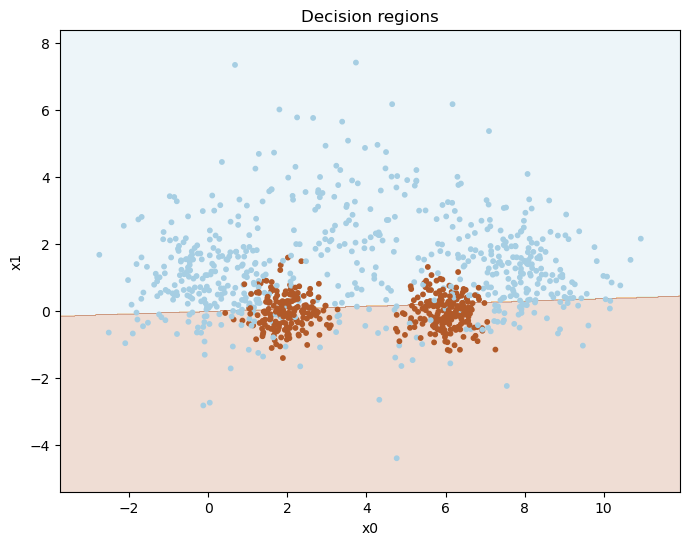

In [203]:
best_eta = 0.04
best_epochs = 350
cl.fit(X_train, t2_train, X_val, t2_val, eta = best_eta, epochs = best_epochs)
plot_decision_regions(X_train, t2_train, cl)

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

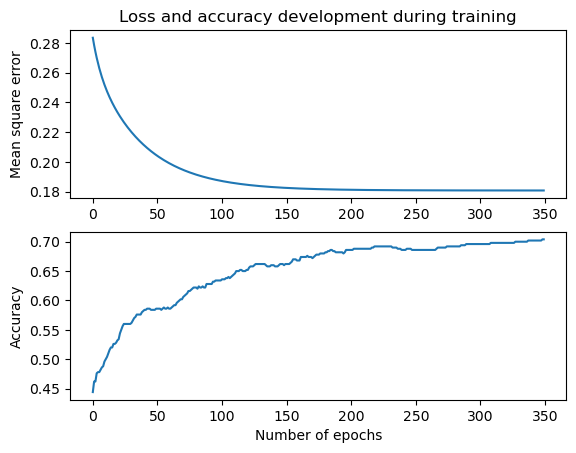

In [204]:
# Training with best hyper-parameter settings
cl.fit(X_train, t2_train, X_val, t2_val, eta = best_eta, epochs = best_epochs)

losses = cl.mse_loss()
accuracies = cl.accuracy_func()


fig, ax = plt.subplots(2)
ax[0].plot(range(best_epochs), losses)
ax[0].set_ylabel('Mean square error')
ax[1].plot(range(best_epochs), accuracies)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of epochs')
ax[0].set_title('Loss and accuracy development during training')
plt.show()

#### Comment:
The functions are monotone which is to be expected. With a learning rate that is too high the function will generally not be monotone.

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

In [205]:
# Implementing scaler (normalizer)

def scale(data):
    mean = np.mean(data, axis = 0) 
    std = np.std(data, axis = 0) 

    scaled = (data - mean)/std
        
    return scaled

In [206]:
# Scaler from w8 (minmax scaler)

class MMScaler():

    def fit(self, X_train):
        self.maxes = np.max(X_train, axis=0)
        self.mins = np.min(X_train, axis=0)
    
    def transform(self, X):
        return (X - self.mins)/(self.maxes - self.mins)

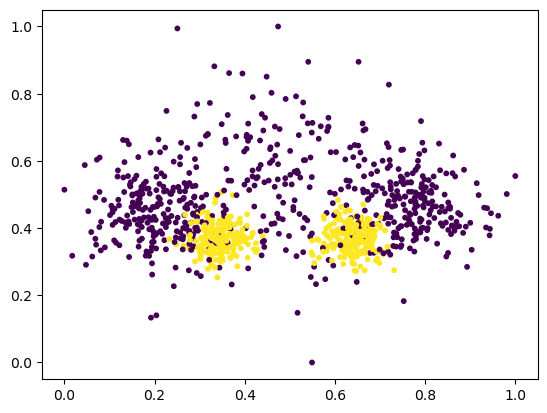

In [207]:
# Scaling data
# scaled_X_train = scale(X_train)
# scaled_X_val = scale(X_val)

sc = MMScaler()
sc.fit(X_train)
scaled_X_train = sc.transform(X_train)

sc.fit(X_val)
scaled_X_val = sc.transform(X_val)


# Plotting the scaled data
plt.scatter(scaled_X_train[:, 0], scaled_X_train[:, 1], c = t2_train, s = 10.0)
plt.show()


# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# scaler.fit(X_train)
# s_X_train = scaler.transform(X_train)

# scaler.fit(t2_train.reshape(1, -1))
# s_t2_train = scaler.transform(t2_train.reshape(1, -1))

# scaler.fit(X_val)
# s_X_val = scaler.transform(X_val)

# scaler.fit(t2_val.reshape(1, -1))
# s_t2_val = scaler.transform(t2_val.reshape(1, -1))

# plt.scatter(scaled_X_train[:, 0], scaled_X_train[:, 1], c = scaled_t2_train, s = 10.0)
# plt.show()

# print(1, scaled_t2_train[-1])
# print(2, s_t2_train[-1])



Experimenting with hyper-parameter settings.

In [208]:
cl_s = NumpyLinRegClass()
cl_s.fit(scaled_X_train, t2_train, scaled_X_val, t2_val)
print(accuracy_(cl_s.predict(scaled_X_val), t2_val))
print(cl_s.accuracy(cl_s.predict(scaled_X_val), t2_val))

0.576
0.576


The accuracy has improved by just using the scaled data.

In [107]:
eta_values = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
epoch_values = [10, 30, 100, 200, 1000, 5000] 


test_hyperpars(scaled_X_train, t2_train, scaled_X_val, t2_val, eta_values, epoch_values)

eta:   0.5    epochs:    10    accuracy:    0.576
eta:   0.5    epochs:    30    accuracy:    0.566
eta:   0.5    epochs:   100    accuracy:    0.770
eta:   0.5    epochs:   200    accuracy:    0.742
eta:   0.5    epochs:  1000    accuracy:    0.690
eta:   0.5    epochs:  5000    accuracy:    0.690
eta:   0.4    epochs:    10    accuracy:    0.576
eta:   0.4    epochs:    30    accuracy:    0.576
eta:   0.4    epochs:   100    accuracy:    0.738
eta:   0.4    epochs:   200    accuracy:    0.752
eta:   0.4    epochs:  1000    accuracy:    0.690
eta:   0.4    epochs:  5000    accuracy:    0.690
eta:   0.3    epochs:    10    accuracy:    0.576
eta:   0.3    epochs:    30    accuracy:    0.576
eta:   0.3    epochs:   100    accuracy:    0.652
eta:   0.3    epochs:   200    accuracy:    0.768
eta:   0.3    epochs:  1000    accuracy:    0.690
eta:   0.3    epochs:  5000    accuracy:    0.690
eta:   0.2    epochs:    10    accuracy:    0.576
eta:   0.2    epochs:    30    accuracy:    0.576


The accuracy improves comparing to the non-scaled data, with the highest accuracy in the test above being 0.770

I am choosing a low enough eta to ensure a monotone loss function, with the lowest possible number of epochs:

eta:  0.05    epochs:  1000    accuracy:    0.770

(Had to pick a lower eta, which only achieved the higest found accuracy yet in 1000 epochs)

Accuracy using scaled data:  0.77
Optimal eta and epochs values: 
eta:  0.05 
epochs:  1000


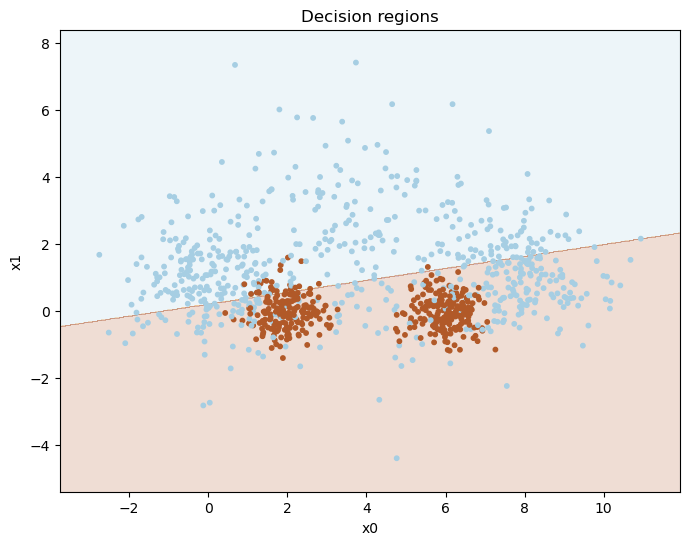

In [227]:
# Training with best hyper-parameter settings for scaled data
best_scaled_eta = 0.05
best_scaled_epochs = 1000

cl = NumpyLinRegClass()
cl.fit(scaled_X_train, t2_train, scaled_X_val, t2_val, eta = best_scaled_eta, epochs = best_scaled_epochs)
print('Accuracy using scaled data: ',cl.accuracy_func()[-1])
print('Optimal eta and epochs values:', '\neta: ', best_scaled_eta, '\nepochs: ', best_scaled_epochs)

plot_decision_regions(X_train, t2_train, cl)

This result is better than with the unscaled data. The accuracy is high even for a lower number of epochs.

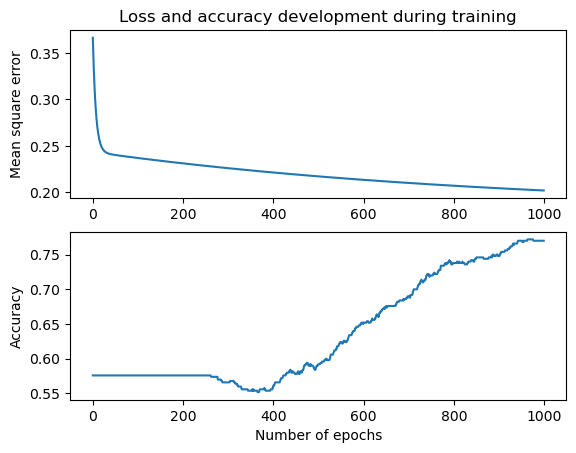

In [228]:
# plotting the loss and the accuracy curve for the classifier trained 
# on scaled data with the best settings found.
losses = cl.mse_loss()
accuracies = cl.accuracy_func()

fig, ax = plt.subplots(2)
ax[0].plot(range(best_scaled_epochs), losses)
ax[0].set_ylabel('Mean square error')
ax[1].plot(range(best_scaled_epochs), accuracies)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of epochs')
ax[0].set_title('Loss and accuracy development during training')
plt.show()


The loss function is not as monotone as expected for the first few values, which might be an indexing error that I have not been able to identify. The MSE decreases very fast, and then stays monotone with a slow decrease for the rest of the epochs.
The accuracy function is not monotone, which is expected.

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [274]:
# Week 7 solution + my own additions:

class NumpyLogReg(NumpyClassifier):

    def __init__(self, bias = 0):
        self.bias = bias
             
    def fit(self, X_train, t_train, X_val, t_val, tol, eta = 0.1, n_epochs_no_update = 5):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""

        X_train_no_bias = np.copy(X_train)
        
        (N, m) = X_train.shape
        X_train = add_bias(X_train, 0)
        
        self.weights = weights = np.zeros(m+1)
        self.loss = loss = []
        self.val_loss = val_loss = []
        self.lr_accuracy = lr_accuracy = []

        i = 0
        test_loss = tol - 1
        for _ in range(200):
            i += 1
            if i > 15 and test_loss < tol:
                # print(f'{n_epochs_no_update} epochs were ran')
                # print('Accuracy: ', e_accuracy[-1])
                self.final_epochs = n_epochs_no_update
                break

            for e in range(n_epochs_no_update):
                weights -= eta / N *  X_train.T @ (self.forward(X_train) - t_train) 
                loss.append(self.CEL(t_train, self.predict(X_train_no_bias))) # X_train bias or no bias, or @ weights?
                # loss.append(self.BCE(t_train, self.predict(X_train_no_bias)))
                val_loss.append(self.CEL(t_train, self.predict(X_val))) # same as for loss?
                # val_loss.append(self.BCE(t_train, self.predict(add_bias(X_val, 0))))
                lr_accuracy.append(np.mean(self.predict(X_val) == t_val))
            test_loss = np.abs(loss[-1] - loss[(n_epochs_no_update - 5)])
            n_epochs_no_update += 1 


    def get_number_of_epochs(self):
        return self.final_epochs
    
    def forward(self, X):
        return self.logistic(X @ self.weights)
    
            # # Logistic (Used in Logistic Regression)
            # def logistic(self, x):
            #     return 1/(1+np.exp(-x))
    
    def predict(self, x, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        z = add_bias(x, 0)
        return (self.forward(z) > threshold).astype('int')
    
    def predict_probability(self, x):
        """Predicts probability of the data
        belonging to the positive class"""
        s = add_bias(x, 0)
        return self.logistic(s @ self.weights)
    
    def bce_loss(self):
        return self.loss[-self.final_epochs:]

    def validation_loss(self):
        return self.val_loss[-self.final_epochs:]
    
    def accuracy_lr(self):
        return self.lr_accuracy[-self.final_epochs:]


In [275]:
lr_cl = NumpyLogReg()
lr_cl.fit(X_train, t2_train, X_val, t2_val, 0.5)

print(lr_cl.accuracy_lr()[-1], lr_cl.get_number_of_epochs())

0.706 120


In 120 epochs the logistic regression model found an accuracy of 0.706 with an eta of 0.1 and a tolerance of 0.5. This is the best value yet for the first test of any model.

In [276]:
# Finding best hyper-parameters
def test_eta_tol(X_train, t_train, X_val, t_val, eta_values, tol_values):
    # Testing various eta and tolerances to increase accuracy

    # varying eta and tol and printing accuracy

    for et in eta_values:
        for tol in tol_values:
            lr_cl.fit(X_train, t_train, X_val, t_val, tol, eta = et)
            print(f"eta: {et:7}    epochs: {lr_cl.get_number_of_epochs():4}    tol: {tol:5}    accuracy: {lr_cl.accuracy_lr()[-1]:8.3f}")


In [131]:
eta_values = [3, 2, 1, 0.1, 0.01, 0.001]
tol_values = [0.001, 0.05, 0.1, 0.5, 1, 1.5]


test_eta_tol(X_train, t2_train, X_val, t2_val, eta_values, tol_values)

eta:       3    epochs:  202    tol: 0.001    accuracy:    0.712
eta:       3    epochs:  173    tol:  0.05    accuracy:    0.712
eta:       3    epochs:  149    tol:   0.1    accuracy:    0.712
eta:       3    epochs:   85    tol:   0.5    accuracy:    0.712
eta:       3    epochs:   69    tol:     1    accuracy:    0.712
eta:       3    epochs:   65    tol:   1.5    accuracy:    0.712
eta:       2    epochs:   65    tol: 0.001    accuracy:    0.712
eta:       2    epochs:  161    tol:  0.05    accuracy:    0.712
eta:       2    epochs:  137    tol:   0.1    accuracy:    0.712
eta:       2    epochs:   38    tol:   0.5    accuracy:    0.574
eta:       2    epochs:   38    tol:     1    accuracy:    0.574
eta:       2    epochs:   34    tol:   1.5    accuracy:    0.574
eta:       1    epochs:  178    tol: 0.001    accuracy:    0.588
eta:       1    epochs:  102    tol:  0.05    accuracy:    0.588
eta:       1    epochs:   90    tol:   0.1    accuracy:    0.588
eta:       1    epochs:  

There seems to be a maximum accuracy of 0.716 when training the unscaled data by logistic regression. I expected to find a higher accuracy for this model.

choosing hyper-parameters for a faster training (few epochs) and the highest accuracy

eta:       1    epochs:   21    tol:   0.5    accuracy:    0.716
eta:    0.01    epochs:   92    tol:   0.5    accuracy:    0.706


In [277]:
best_tol = 0.5
best_eta = 1

lr_cl.fit(X_train, t2_train, X_val, t2_val, best_tol, eta = best_eta)

print(lr_cl.get_number_of_epochs(), lr_cl.accuracy_lr()[-1])

45 0.716


A high accuracy is found in few epochs, but this accuracy value could be higher considering the much higher accuracy found in linear regression on scaled data.

In [144]:
# Same test on scaled data:
eta_values = [1, 0.1, 0.01]
tol_values = [0.05, 0.1, 0.5]

test_eta_tol(scaled_X_train, t2_train, scaled_X_val, t2_val, eta_values, tol_values)

eta:       1    epochs:  175    tol:  0.05    accuracy:    0.658
eta:       1    epochs:   24    tol:   0.1    accuracy:    0.672
eta:       1    epochs:   20    tol:   0.5    accuracy:    0.654
eta:     0.1    epochs:   20    tol:  0.05    accuracy:    0.658
eta:     0.1    epochs:  284    tol:   0.1    accuracy:    0.658
eta:     0.1    epochs:   20    tol:   0.5    accuracy:    0.576
eta:    0.01    epochs:   20    tol:  0.05    accuracy:    0.658
eta:    0.01    epochs:   20    tol:   0.1    accuracy:    0.576
eta:    0.01    epochs:   20    tol:   0.5    accuracy:    0.576


Neither of these accuracies are good compared to earlier values. The logistic regression model seems to do a lot better on unscaled data.

Choosing the hyper-parameters yielding the fewest epochs and highest accuracy.

eta:       1    epochs:   24    tol:   0.1    accuracy:    0.672

In [278]:
best_tol = 0.1
best_eta = 1

lr_cl.fit(scaled_X_train, t2_train, scaled_X_val, t2_val, best_tol, eta = best_eta)

print(lr_cl.get_number_of_epochs(), lr_cl.accuracy_lr()[-1])

45 0.658


The best accuracy in the logistic regression model is 0.672, found in 24 epochs. The logistic regression model performs better, at least on this data, with unscaled data.

In [279]:
# Final training using the best data (not scaled)

best_tol = 0.5
best_eta = 0.1

lr_cl.fit(X_train, t2_train, X_val, t2_val, best_tol, best_eta)

print(lr_cl.accuracy_lr()[-1], lr_cl.get_number_of_epochs())

0.706 120


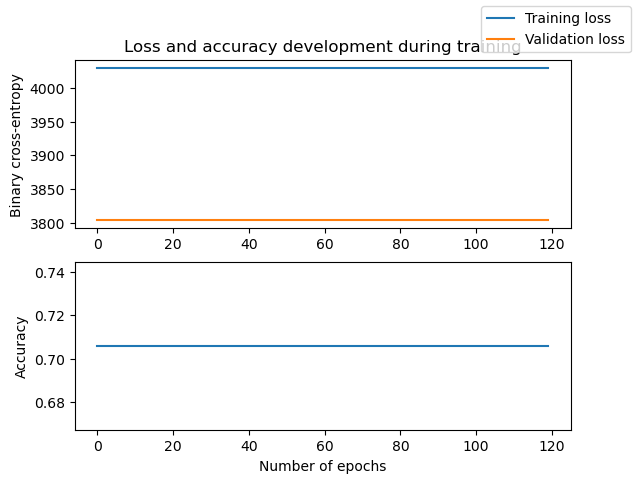

In [280]:
# Plotting training loss and validation loss vs. epochs
# Plotting accuracies vs. epochs

epochs = lr_cl.get_number_of_epochs()
losses = lr_cl.bce_loss()
val_losses = lr_cl.validation_loss()
accuracies = lr_cl.accuracy_lr()

fig, ax = plt.subplots(2)
ax[0].plot(range(epochs), losses, label = 'Training loss')
ax[0].plot(range(epochs), val_losses, label = 'Validation loss')
ax[0].set_ylabel('Binary cross-entropy')
ax[1].plot(range(epochs), accuracies)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of epochs')
ax[0].set_title('Loss and accuracy development during training')
fig.legend()
plt.show()


This plot looks completely wrong. I do not know why these values are not changing at all. However, I can not identify where this is happening specifically. The model does not even improve over the epochs. 

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [414]:
class OneVsRest():

    def OvRfit(self, X_train, t_multi_train, X_val, t_multi_val, tol, eta, C = 5):
        # C - number of classes
        self.C = C
        self.t_train_hot = t_train_hot = self.oneHot(t_multi_train)
        self.t_val_hot = t_val_hot = self.oneHot(t_multi_val)

        lc = NumpyLogReg()
        self.list_of_logclass = list_of_logclass = []
        self.predictions = predictions = np.zeros(shape = (C, int(X_val.size/2)))
        self.accuracies = accuracies = np.zeros(C)

        for i in range(C):
            list_of_logclass.append(lc)
            lc.fit(X_train, t_train_hot[:, i], X_val, t_val_hot[:, i], tol, eta)
            predictions[i] = lc.predict(X_val)
            self.weights = lc.weights
            accuracies[i] = np.mean(lc.predict(X_val) == t_val_hot[:, i])
            print("Accuracy for class ",i, ": ", accuracies[i])
        
        # probs = self.predict_probability()
        # print("probs ", probs)
        # class_predicted = self.predict_class()
        # print("Class predicted ", class_predicted)
            

    def oneHot(self, X):
        x = np.zeros((X.size, X.max() + 1))
        x[np.arange(X.size), X] = 1
        return x
        
    def predict_probability(self):
        # (n x C) table of n inputs and C classes
        return self.predictions
    
    def predict_class(self):
        # (n) shaped array of predictions, NOT onehot encoded
        x = self.predict_probability().argmax(axis = 0)
        return x
    
    def predict(self, x, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        z = add_bias(x, 0)
        return (self.forward(z) > threshold).astype('int')
    
    def forward(self, X):
        return self.logistic(X @ self.weights)
    
    def logistic(self, x):
        return 1/(1+np.exp(-x))

 


In [415]:
ovr_cl = OneVsRest()
ovr_cl.OvRfit(X_train, t_multi_train, X_val, t_multi_val, 0.5, 0.1)

Accuracy for class  0 :  0.91
Accuracy for class  1 :  0.74
Accuracy for class  2 :  0.674
Accuracy for class  3 :  0.77
Accuracy for class  4 :  0.674


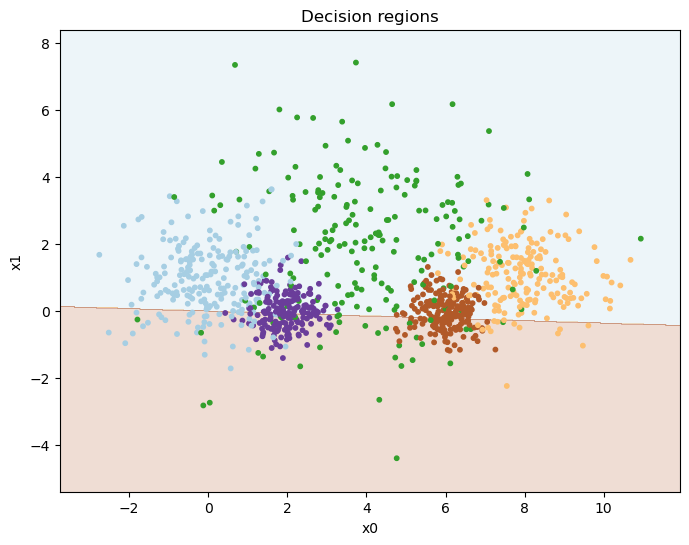

In [416]:
plot_decision_regions(X_train, t_multi_train, ovr_cl)

This only plots one decision region, which is not what I was expecting. I was expecting five different decision regions based on the probability of a datapoint beloning to that dataset compared to the rest of the data.

# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [346]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, eta=0.001, epochs = 100):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Itilaize the wights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights
            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)

In [347]:
def fit_accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [348]:
mlp = MLPBinaryLinRegClass()
mlp.fit(X_train, t2_train)

print(fit_accuracy(mlp.predict(X_val), t2_val))

0.666


In [353]:
# Finding best hyper-parameters
def tune_MLP(X_train, t_train, X_val, t_val, eta_values, epoch_values):
    # Testing various eta and tolerances to increase accuracy
    mlp = MLPBinaryLinRegClass()
    # varying eta and tol and printing accuracy

    for et in eta_values:
        for ep in epoch_values:
            mlp.fit(X_train, t_train, eta = et, epochs = ep)
            print(f"eta: {et:7}    epochs: {ep:7}   accuracy: {fit_accuracy(mlp.predict(X_val), t_val):8.3f}")

In [368]:
eta_values = [10, 0.01, 0.001, 0.0005, 0.0001, 0.00001]
epoch_values = [10, 5000, 10000, 20000, 40000, 50000]

tune_MLP(X_train, t2_train, X_val, t2_val, eta_values, epoch_values)

/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/3619876166.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/3619876166.py:46: RuntimeWarning: overflow encountered in matmul
  hiddenout_diffs = out_deltas @ self.weights2.T
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/3619876166.py:48: RuntimeWarning: invalid value encountered in multiply
  hiddenact_deltas = (hiddenout_diffs[:, 1:] *


eta:      10    epochs:      10   accuracy:    0.424
eta:      10    epochs:    5000   accuracy:    0.576
eta:      10    epochs:   10000   accuracy:    0.576
eta:      10    epochs:   20000   accuracy:    0.576
eta:      10    epochs:   40000   accuracy:    0.576
eta:      10    epochs:   50000   accuracy:    0.576
eta:    0.01    epochs:      10   accuracy:    0.576
eta:    0.01    epochs:    5000   accuracy:    0.576
eta:    0.01    epochs:   10000   accuracy:    0.576
eta:    0.01    epochs:   20000   accuracy:    0.576
eta:    0.01    epochs:   40000   accuracy:    0.576
eta:    0.01    epochs:   50000   accuracy:    0.576
eta:   0.001    epochs:      10   accuracy:    0.576
eta:   0.001    epochs:    5000   accuracy:    0.822
eta:   0.001    epochs:   10000   accuracy:    0.896
eta:   0.001    epochs:   20000   accuracy:    0.840
eta:   0.001    epochs:   40000   accuracy:    0.850
eta:   0.001    epochs:   50000   accuracy:    0.886
eta:  0.0005    epochs:      10   accuracy:   

The results improve with the number of epochs, but seems to work best with a very low eta and a lot of epochs. The optimal eta is around 0.0005, where the accuracy improves with the number of epochs.

Some chosen run values:

eta:  0.0001    epochs:   20000   accuracy:    0.896
eta:   0.001    epochs:   30000   accuracy:    0.904
eta:   0.001    epochs:   30000   accuracy:    0.842
eta:  0.0005    epochs:   10000   accuracy:    0.898
eta:   0.001    epochs:   10000   accuracy:    0.896
eta:  0.0005    epochs:   20000   accuracy:    0.890
eta:  0.0005    epochs:   50000   accuracy:    0.898




The optimal hyper-parameters to move forward with, where the accuracy is higher with every tuning test, is:

eta:  0.0005    epochs:   50000   accuracy:    0.898


In [382]:
mlp = MLPBinaryLinRegClass()
mlp.fit(X_train, t2_train, eta = 0.0005, epochs = 50000)
accuracy_mlp = fit_accuracy(mlp.predict(X_val), t2_val)
print(accuracy_mlp)

0.9


In this run the accuracy was 0.9. Plotting the decision regions:

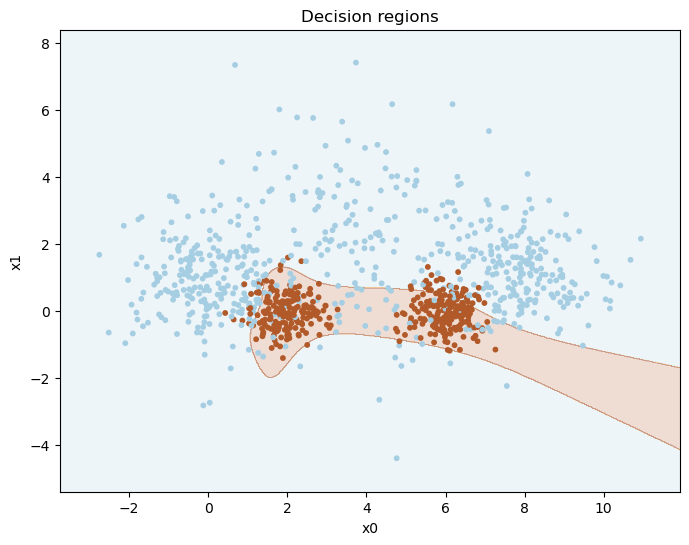

In [379]:
# plotting decision regions

plot_decision_regions(X_train, t2_train, mlp)

This is a significant improvement from the linear and logistic models, and has a very high accuracy. The MLP training yielding the accuracy of 0.9 and the plot above ran in only 12 seconds on my computer, which is a lot faster than both earlier models.

## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

In [478]:
class MLPBinaryLinRegClassV2(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, X_val, t_val, eta=0.001, tol = 0.5):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Itilaize the wights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        self.loss = loss = []
        self.accuracies = accuracies = []
        n_epochs_no_update = 5

        i = 0
        test_loss = tol - 1
        for _ in range(1000):
            i += 1
            if i > 50 and test_loss < tol:
                # print('Accuracy: ', accuracies[-1], "Epochs: ", n_epochs_no_update)
                self.final_epochs = n_epochs_no_update
                break

            for e in range(epochs):
                # One epoch
                hidden_outs, outputs = self.forward(X_train_bias)
                # The forward step
                out_deltas = (outputs - T_train)
                # The delta term on the output node
                hiddenout_diffs = out_deltas @ self.weights2.T
                # The delta terms at the output of the jidden layer
                hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                    self.activ_diff(hidden_outs[:, 1:]))  
                # The deltas at the input to the hidden layer
                self.weights2 -= self.eta * hidden_outs.T @ out_deltas
                self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
                # Update the weights
                loss.append(self.MSE(t_train, self.predict(X_train)))
                accuracies.append(self.accuracy(self.predict(X_val), t_val))
            test_loss = np.abs(loss[-1] - loss[(n_epochs_no_update - 5)])
            n_epochs_no_update += 1 

    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score = forw[:, 0]
        return (score > 0.5)

    def predict_probability(self, x):
        """Predicts probability of the data
        belonging to the positive class""" 
        s = add_bias(x, self.bias)
        logist = self.logistic(s)[1]
        score = logist[:, 0] 
        return (score > 0.5)

    def get_loss_accuracies_epochs(self):
        return self.loss[-self.final_epochs:], self.accuracies[-self.final_epochs:], self.final_epochs
    

In [479]:
mlp2 = MLPBinaryLinRegClassV2()

mlp2.fit(X_train, t2_train, X_val, t2_val, eta=0.0001, tol = 0.9)
loss, accuracy, epochs = mlp2.get_loss_accuracies_epochs()
print(accuracy[-1], epochs)


0.838 55


In [481]:
eta_values = [1, 0.01, 0.001, 0.0001, 0.00001]
tol_values = [0.001, 0.01, 0.5, 1, 1.5]

for et in eta_values:
        for tol in tol_values:
            mlp2.fit(X_train, t2_train, X_val, t2_val, eta = et, tol = tol) 
            loss, accuracy, epochs = mlp2.get_loss_accuracies_epochs()
            print(f"eta: {et:7}   tol: {tol:7}  epochs: {epochs:4}  accuracy: {accuracy[-1]:7.3f}")    

/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2400032584.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2400032584.py:59: RuntimeWarning: overflow encountered in matmul
  hiddenout_diffs = out_deltas @ self.weights2.T
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2400032584.py:61: RuntimeWarning: invalid value encountered in multiply
  hiddenact_deltas = (hiddenout_diffs[:, 1:] *


eta:       1   tol:   0.001  epochs:   55  accuracy:   0.576
eta:       1   tol:    0.01  epochs:   55  accuracy:   0.576
eta:       1   tol:     0.5  epochs:   55  accuracy:   0.576
eta:       1   tol:       1  epochs:   55  accuracy:   0.576
eta:       1   tol:     1.5  epochs:   55  accuracy:   0.576
eta:    0.01   tol:   0.001  epochs:   55  accuracy:   0.576
eta:    0.01   tol:    0.01  epochs:   55  accuracy:   0.576
eta:    0.01   tol:     0.5  epochs:   55  accuracy:   0.576
eta:    0.01   tol:       1  epochs:   55  accuracy:   0.576
eta:    0.01   tol:     1.5  epochs:   55  accuracy:   0.576
eta:   0.001   tol:   0.001  epochs:   55  accuracy:   0.832
eta:   0.001   tol:    0.01  epochs:   71  accuracy:   0.828
eta:   0.001   tol:     0.5  epochs:   55  accuracy:   0.802
eta:   0.001   tol:       1  epochs:   55  accuracy:   0.806
eta:   0.001   tol:     1.5  epochs:   55  accuracy:   0.814
eta:  0.0001   tol:   0.001  epochs:   55  accuracy:   0.886
eta:  0.0001   tol:    0

With higer eta, the tolerance does not seem to matter. This has to do wioth the way the tolerance is implemented. for a very low eta, the tolerance ensures that more than 55 epochs run, and that we get a better accuracy. However, the best results (accuracy) come from lower eta values.

The accuracy is higest for eta values between 0.001 and 0.0001. The tolerance does not seem to matter, which is probably due to my implementation not being optimal.

I will chose these values if the training on scaled data is not better.
eta:  0.0001   tol:   0.001  epochs:   55  accuracy:   0.886


In [483]:
# Is scaled data better?

eta_values = [1, 0.01, 0.001, 0.0001, 0.00001]
tol_values = [0.001, 0.01, 0.5, 1, 1.5]

for et in eta_values:
        for tol in tol_values:
            mlp2.fit(scaled_X_train, t2_train, scaled_X_val, t2_val, eta = et, tol = tol) 
            loss, accuracy, epochs = mlp2.get_loss_accuracies_epochs()
            print(f"eta: {et:5}   tol: {tol:7}  epochs: {epochs:4}  accuracy: {accuracy[-1]:7.3f}")  

/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2400032584.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2400032584.py:59: RuntimeWarning: overflow encountered in matmul
  hiddenout_diffs = out_deltas @ self.weights2.T
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2400032584.py:61: RuntimeWarning: invalid value encountered in multiply
  hiddenact_deltas = (hiddenout_diffs[:, 1:] *


eta:     1   tol:   0.001  epochs:   55  accuracy:   0.576
eta:     1   tol:    0.01  epochs:   55  accuracy:   0.576
eta:     1   tol:     0.5  epochs:   55  accuracy:   0.576
eta:     1   tol:       1  epochs:   55  accuracy:   0.576
eta:     1   tol:     1.5  epochs:   55  accuracy:   0.576


/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_77971/2400032584.py:64: RuntimeWarning: overflow encountered in matmul
  self.weights2 -= self.eta * hidden_outs.T @ out_deltas


eta:  0.01   tol:   0.001  epochs:   56  accuracy:   0.576
eta:  0.01   tol:    0.01  epochs:   55  accuracy:   0.576
eta:  0.01   tol:     0.5  epochs:   55  accuracy:   0.576
eta:  0.01   tol:       1  epochs:   55  accuracy:   0.576
eta:  0.01   tol:     1.5  epochs:   55  accuracy:   0.576
eta: 0.001   tol:   0.001  epochs:   55  accuracy:   0.690
eta: 0.001   tol:    0.01  epochs:   55  accuracy:   0.664
eta: 0.001   tol:     0.5  epochs:   55  accuracy:   0.748
eta: 0.001   tol:       1  epochs:   55  accuracy:   0.690
eta: 0.001   tol:     1.5  epochs:   55  accuracy:   0.658
eta: 0.0001   tol:   0.001  epochs:   55  accuracy:   0.804
eta: 0.0001   tol:    0.01  epochs:   55  accuracy:   0.630
eta: 0.0001   tol:     0.5  epochs:   55  accuracy:   0.660
eta: 0.0001   tol:       1  epochs:   55  accuracy:   0.718
eta: 0.0001   tol:     1.5  epochs:   55  accuracy:   0.758
eta: 1e-05   tol:   0.001  epochs:   55  accuracy:   0.576
eta: 1e-05   tol:    0.01  epochs:   55  accuracy: 

The accuracy results are similar to the test on unscaled data, but not improved. The model trains better on unscaled data for these datasets.

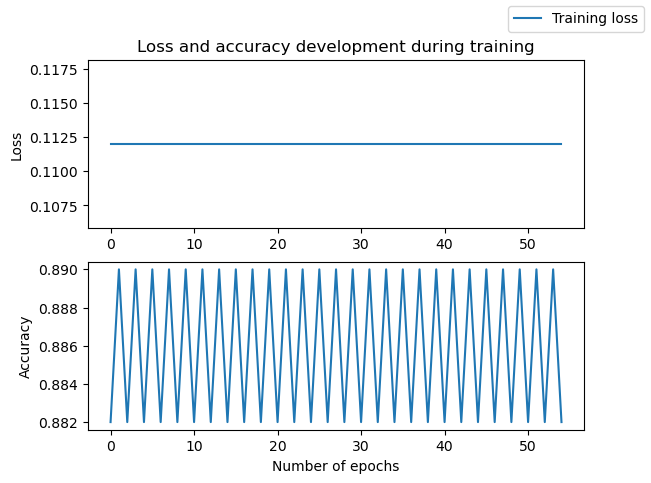

In [489]:
# Plotting training loss vs. epochs
# Plotting accuracies vs. epochs

# eta:  0.0001   tol:   0.001  epochs:   55  accuracy:   0.886


best_eta = 0.0001
best_tol = 0.001

mlp2.fit(X_train, t2_train, X_val, t2_val, best_eta, best_tol)

losses, accuracies, epochs = mlp2.get_loss_accuracies_epochs()

fig, ax = plt.subplots(2)
ax[0].plot(range(epochs), losses, label = 'Training loss')
ax[0].set_ylabel('Loss')
ax[1].plot(range(epochs), accuracies)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of epochs')
ax[0].set_title('Loss and accuracy development during training')
fig.legend()
plt.show()

These plots are again completely off. The loss function should decrease monotonically, and the accuracy function increase (not nesessarily evenly). During the training plotted there is zero improvement on the model throughout the epochs.

In [490]:
# g) The algorithm contains an element of non-determinism. 
# Hence, train the classifier 10 times with the optimal 
# hyper-parameters and report the mean and standard deviation 
# of the accuracies over the 10 runs.

best_eta = 0.0001
best_tol = 0.001

accuracies = []

for i in range(10):
    mlp2.fit(X_train, t2_train, X_val, t2_val, best_eta, best_tol)
    losses, accuracies, epochs = mlp2.get_loss_accuracies_epochs()
    accuracies.append(accuracies[-1])

print(f"Mean accuracy: {np.mean(accuracies)}, std: {np.std(accuracies)}")

Mean accuracy: 0.896, std: 0.0


A mean accuracy of 0.896 is decently good. There is no variance in the accuracies, which is explaied by the earlier plot, where we can see that the accuracy just seems to switch between a few values, and not improving over time.

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.

In [491]:
lc = NumpyLinRegClass()
lr_cl = NumpyLogReg()
mlp2 = MLPBinaryLinRegClassV2()

# Training with the best hyper-parameters
cl.fit(X_train, t2_train, X_val, t2_val, eta = 0.04, epochs = 350)
lr_cl.fit(X_train, t2_train, X_val, t2_val, 0.5, 0.1)
mlp2.fit(X_train, t2_train, X_val, t2_val, eta = 0.0001, tol = 0.001)


In [512]:
print("                 |Accuracies: ")
print("Test data:       |  Linear regression   |   Logistic regression  | Multi-layer network")
print(f"Test set:        |         {accuracy_(cl.predict(X_test), t2_test)}        |         {accuracy_(lr_cl.predict(X_test), t2_test)}          |         {accuracy_(mlp2.predict(X_test), t2_test)} ")
print(f"Validation set:  |         {accuracy_(cl.predict(X_val), t2_val)}        |         {accuracy_(lr_cl.predict(X_val), t2_val)}          |         {accuracy_(mlp2.predict(X_val), t2_val)} ")
print(f"Training set:    |         {accuracy_(cl.predict(X_train), t2_train)}        |         {accuracy_(lr_cl.predict(X_train), t2_train)}           |         {accuracy_(mlp2.predict(X_train), t2_train)} ")

                 |Accuracies: 
Test data:       |  Linear regression   |   Logistic regression  | Multi-layer network
Test set:        |         0.724        |         0.726          |         0.886 
Validation set:  |         0.704        |         0.706          |         0.886 
Training set:    |         0.751        |         0.75           |         0.894 


For all models, the training set has the highest accuracy. The held-out test set performed better or similar to the validation set, but not as good as the training set. I was expecting lower results on the held-out test set compared to the validation set, but they were higher for both the linear and the logistic regression models. This might be due to the validation set being made in a way of seeking a higher accuracy, because it is harder to achieve a high accuracy with the validation set, and thus resulting in better training of the model in the end.